In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
cd gdrive/MyDrive/

Mounted at /content/gdrive


In [ ]:
#@title Import Libraries
import os
import os.path as osp
import pickle
import numpy as np
import itertools
import matplotlib.pyplot as plt
import scipy.sparse as sp
import urllib
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

In [ ]:
#@title Define Data Structure
Data = namedtuple('Data', ['x', 'y', 'adjacency_dict', 'train_mask', 'val_mask', 'test_mask'])

class CoraData(object):
    filenames = ["ind.cora.{}".format(name) for name in
                 ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']]

    def __init__(self, data_root="./data/cora"):
        """
        处理之后的数据可以通过属性 .data 获得，它将返回一个数据对象，包括如下几部分：
            * x: 节点的特征，维度为 2708 * 1433，类型为 np.ndarray
            * y: 节点的标签，总共包括7个类别，类型为 np.ndarray
            * adjacency_dict: 邻接信息，，类型为 dict
            * train_mask: 训练集掩码向量，维度为 2708，当节点属于训练集时，相应位置为True，否则False
            * val_mask: 验证集掩码向量，维度为 2708，当节点属于验证集时，相应位置为True，否则False
            * test_mask: 测试集掩码向量，维度为 2708，当节点属于测试集时，相应位置为True，否则False
        Args:
        -------
            data_root: string, optional
                存放数据的目录，原始数据路径: ../data/cora
                缓存数据路径: {data_root}/ch7_cached.pkl
        """
        self.data_root = data_root
        save_file = osp.join(self.data_root, "ch7_cached.pkl")
        if osp.exists(save_file):
            print("Using Cached file: {}".format(save_file))
            self._data = pickle.load(open(save_file, "rb"))
        else:
            self._data = self.process_data()
            with open(save_file, "wb") as f:
                pickle.dump(self._data, f)
            print("Cached file: {}".format(save_file))

    @property
    def data(self):
        """返回Data数据对象，包括x, y, adjacency, train_mask, val_mask, test_mask"""
        return self._data

    def process_data(self):
        print("Process data ...")
        _, tx, allx, y, ty, ally, graph, test_index = [self.read_data(osp.join(self.data_root, name)) for name in self.filenames]
        train_index = np.arange(y.shape[0])
        val_index = np.arange(y.shape[0], y.shape[0] + 500)
        sorted_test_index = sorted(test_index)

        x = np.concatenate((allx, tx), axis=0)
        y = np.concatenate((ally, ty), axis=0).argmax(axis=1)

        x[test_index] = x[sorted_test_index]
        y[test_index] = y[sorted_test_index]
        num_nodes = x.shape[0]

        train_mask = np.zeros(num_nodes, dtype=np.bool)
        val_mask = np.zeros(num_nodes, dtype=np.bool)
        test_mask = np.zeros(num_nodes, dtype=np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        adjacency_dict = graph
        print("Node's feature shape: ", x.shape)
        print("Node's label shape: ", y.shape)
        print("Adjacency's shape: ", len(adjacency_dict))
        print("Number of training nodes: ", train_mask.sum())
        print("Number of validation nodes: ", val_mask.sum())
        print("Number of test nodes: ", test_mask.sum())

        return Data(x=x, y=y, adjacency_dict=adjacency_dict, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

    @staticmethod
    def build_adjacency(adj_dict):
        """根据邻接表创建邻接矩阵"""
        edge_index = []
        num_nodes = len(adj_dict)
        for src, dst in adj_dict.items():
            edge_index.extend([src, v] for v in dst)
            edge_index.extend([v, src] for v in dst)
        # 去除重复的边
        edge_index = list(k for k, _ in itertools.groupby(sorted(edge_index)))
        edge_index = np.asarray(edge_index)
        adjacency = sp.coo_matrix((np.ones(len(edge_index)), (edge_index[:, 0], edge_index[:, 1])), shape=(num_nodes, num_nodes), dtype="float32")
        return adjacency

    @staticmethod
    def read_data(path):
        """使用不同的方式读取原始数据以进一步处理"""
        name = osp.basename(path)
        if name == "ind.cora.test.index":
            out = np.genfromtxt(path, dtype="int64")
            return out
        else:
            out = pickle.load(open(path, "rb"), encoding="latin1")
            out = out.toarray() if hasattr(out, "toarray") else out
            return out

In [ ]:
#@title Sampling
def sampling(src_nodes, sample_num, neighbor_table):
    """根据源节点采样指定数量的邻居节点，注意使用的是有放回的采样；
    某个节点的邻居节点数量少于采样数量时，采样结果出现重复的节点
    
    Arguments:
        src_nodes {list, ndarray} -- 源节点列表
        sample_num {int} -- 需要采样的节点数
        neighbor_table {dict} -- 节点到其邻居节点的映射表
    
    Returns:
        np.ndarray -- 采样结果构成的列表
    """
    results = []
    for sid in src_nodes:
        # 从节点的邻居中进行有放回地进行采样
        res = np.random.choice(neighbor_table[sid], size=(sample_num,))
        results.append(res)
    return np.asarray(results).flatten()

def multihop_sampling(src_nodes, sample_nums, neighbor_table):
    """根据源节点进行多阶采样
    Arguments:
        src_nodes {list, np.ndarray} -- 源节点id
        sample_nums {list of int} -- 每一阶需要采样的个数
        neighbor_table {dict} -- 节点到其邻居节点的映射
    Returns:
        [list of ndarray] -- 每一阶采样的结果
    """
    sampling_result = [src_nodes]
    for k, hopk_num in enumerate(sample_nums):
        hopk_result = sampling(sampling_result[k], hopk_num, neighbor_table)
        sampling_result.append(hopk_result)
    return sampling_result


In [ ]:
class NeighborAggregator(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=False, aggr_method="mean"):
        """聚合节点邻居
        Args:
            input_dim: 输入特征的维度
            output_dim: 输出特征的维度
            use_bias: 是否使用偏置 (default: {False})
            aggr_method: 邻居聚合方式 (default: {mean})
        """
        super(NeighborAggregator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.aggr_method = aggr_method
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(self.output_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, neighbor_feature):
        if self.aggr_method == "mean":
            aggr_neighbor = neighbor_feature.mean(dim=1)
        elif self.aggr_method == "sum":
            aggr_neighbor = neighbor_feature.sum(dim=1)
        elif self.aggr_method == "max":
            aggr_neighbor = neighbor_feature.max(dim=1)
        else:
            raise ValueError("Unknown aggr type, expected sum, max, or mean, but got {}".format(self.aggr_method))
        
        neighbor_hidden = torch.matmul(aggr_neighbor, self.weight)
        if self.use_bias:
            neighbor_hidden += self.bias
        return neighbor_hidden

    def extra_repr(self):
        return 'in_features={}, out_features={}, aggr_method={}'.format(self.input_dim, self.output_dim, self.aggr_method)
    

class SageGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=F.relu, aggr_neighbor_method="mean", aggr_hidden_method="sum"):
        """SageGCN层定义
        Args:
            input_dim: 输入特征的维度
            hidden_dim: 隐层特征的维度，
                当aggr_hidden_method=sum, 输出维度为hidden_dim
                当aggr_hidden_method=concat, 输出维度为hidden_dim*2
            activation: 激活函数
            aggr_neighbor_method: 邻居特征聚合方法，["mean", "sum", "max"]
            aggr_hidden_method: 节点特征的更新方法，["sum", "concat"]
        """
        super(SageGCN, self).__init__()
        assert aggr_neighbor_method in ["mean", "sum", "max"]
        assert aggr_hidden_method in ["sum", "concat"]
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.aggr_neighbor_method = aggr_neighbor_method
        self.aggr_hidden_method = aggr_hidden_method
        self.activation = activation
        self.aggregator = NeighborAggregator(input_dim, hidden_dim, aggr_method=aggr_neighbor_method)
        self.weight = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)

    def forward(self, src_node_features, neighbor_node_features):
        neighbor_hidden = self.aggregator(neighbor_node_features)
        self_hidden = torch.matmul(src_node_features, self.weight)
        
        if self.aggr_hidden_method == "sum":
            hidden = self_hidden + neighbor_hidden
        elif self.aggr_hidden_method == "concat":
            hidden = torch.cat([self_hidden, neighbor_hidden], dim=1)
        else:
            raise ValueError("Expected sum or concat, got {}"
                             .format(self.aggr_hidden))
        if self.activation:
            return self.activation(hidden)
        else:
            return hidden

    def extra_repr(self):
        output_dim = self.hidden_dim if self.aggr_hidden_method == "sum" else self.hidden_dim * 2
        return 'in_features={}, out_features={}, aggr_hidden_method={}'.format(self.input_dim, output_dim, self.aggr_hidden_method)


class GraphSage(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_neighbors_list):
        super(GraphSage, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_neighbors_list = num_neighbors_list
        self.num_layers = len(num_neighbors_list)
        self.gcn = nn.ModuleList()
        self.gcn.append(SageGCN(input_dim, hidden_dim[0]))
        for index in range(0, len(hidden_dim) - 2):
            self.gcn.append(SageGCN(hidden_dim[index], hidden_dim[index+1]))
        self.gcn.append(SageGCN(hidden_dim[-2], hidden_dim[-1], activation=None))

    def forward(self, node_features_list):
        hidden = node_features_list
        for l in range(self.num_layers):
            next_hidden = []
            gcn = self.gcn[l]
            for hop in range(self.num_layers - l):
                src_node_features = hidden[hop]
                src_node_num = len(src_node_features)
                neighbor_node_features = hidden[hop + 1] \
                    .view((src_node_num, self.num_neighbors_list[hop], -1))
                h = gcn(src_node_features, neighbor_node_features)
                next_hidden.append(h)
            hidden = next_hidden
        return hidden[0]

    def extra_repr(self):
        return 'in_features={}, num_neighbors_list={}'.format(self.input_dim, self.num_neighbors_list)

In [ ]:
def train():
    model.train()
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
            batch_src_label = torch.from_numpy(train_label[batch_src_index]).long().to(DEVICE)
            batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
            batch_sampling_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in batch_sampling_result]
            batch_train_logits = model(batch_sampling_x)
            loss = criterion(batch_train_logits, batch_src_label)
            optimizer.zero_grad()
            loss.backward()  # 反向传播计算参数的梯度
            optimizer.step()  # 使用优化方法进行梯度更新
            print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss.item()))
        test_logits, test_label = test()
    return test_logits, test_label

def test():
    model.eval()
    with torch.no_grad():
        test_sampling_result = multihop_sampling(test_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
        test_x = [torch.from_numpy(x[idx]).float().to(DEVICE) for idx in test_sampling_result]
        test_logits = model(test_x)
        test_label = torch.from_numpy(data.y[test_index]).long().to(DEVICE)
        predict_y = test_logits.max(1)[1]
        accuarcy = torch.eq(predict_y, test_label).float().mean().item()
        print("Test Accuracy: ", accuarcy)
    return test_logits, test_label

In [ ]:
INPUT_DIM = 1433    # 输入维度
# Note: 采样的邻居阶数需要与GCN的层数保持一致
HIDDEN_DIM = [128, 7]   # 隐藏单元节点数
NUM_NEIGHBORS_LIST = [10, 10]   # 每阶采样邻居的节点数
assert len(HIDDEN_DIM) == len(NUM_NEIGHBORS_LIST)
BTACH_SIZE = 16     # 批处理大小
EPOCHS = 20
NUM_BATCH_PER_EPOCH = 20    # 每个epoch循环的批次数
LEARNING_RATE = 0.01    # 学习率
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data = CoraData().data
x = data.x / data.x.sum(1, keepdims=True)  # 归一化数据，使得每一行和为1

train_index = np.where(data.train_mask)[0]
train_label = data.y
test_index = np.where(data.test_mask)[0]
model = GraphSage(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_neighbors_list=NUM_NEIGHBORS_LIST).to(DEVICE)
print(model)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)

Process data ...
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  2708
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: ./data/cora/ch7_cached.pkl
GraphSage(
  in_features=1433, num_neighbors_list=[10, 10]
  (gcn): ModuleList(
    (0): SageGCN(
      in_features=1433, out_features=128, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=1433, out_features=128, aggr_method=mean)
    )
    (1): SageGCN(
      in_features=128, out_features=7, aggr_hidden_method=sum
      (aggregator): NeighborAggregator(in_features=128, out_features=7, aggr_method=mean)
    )
  )
)


Epoch 000 Batch 000 Loss: 0.0418
Epoch 000 Batch 001 Loss: 0.0456
Epoch 000 Batch 002 Loss: 0.0533
Epoch 000 Batch 003 Loss: 0.0421
Epoch 000 Batch 004 Loss: 0.0243
Epoch 000 Batch 005 Loss: 0.0573
Epoch 000 Batch 006 Loss: 0.0561
Epoch 000 Batch 007 Loss: 0.0470
Epoch 000 Batch 008 Loss: 0.0417
Epoch 000 Batch 009 Loss: 0.0641
Epoch 000 Batch 010 Loss: 0.0352
Epoch 000 Batch 011 Loss: 0.0317
Epoch 000 Batch 012 Loss: 0.0549
Epoch 000 Batch 013 Loss: 0.0449
Epoch 000 Batch 014 Loss: 0.0339
Epoch 000 Batch 015 Loss: 0.0465
Epoch 000 Batch 016 Loss: 0.0455
Epoch 000 Batch 017 Loss: 0.0322
Epoch 000 Batch 018 Loss: 0.0493
Epoch 000 Batch 019 Loss: 0.0386
Test Accuracy:  0.7789999842643738
Epoch 001 Batch 000 Loss: 0.0368
Epoch 001 Batch 001 Loss: 0.0384
Epoch 001 Batch 002 Loss: 0.0333
Epoch 001 Batch 003 Loss: 0.0299
Epoch 001 Batch 004 Loss: 0.0474
Epoch 001 Batch 005 Loss: 0.0424
Epoch 001 Batch 006 Loss: 0.0447
Epoch 001 Batch 007 Loss: 0.0285
Epoch 001 Batch 008 Loss: 0.0299
Epoch 00

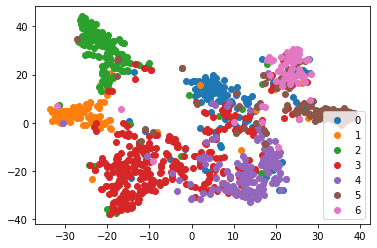

In [ ]:
test_logits, test_label = train()
# 绘制测试数据的TSNE降维图
from sklearn.manifold import TSNE
tsne = TSNE()
out = tsne.fit_transform(test_logits)
fig = plt.figure()
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.legend()